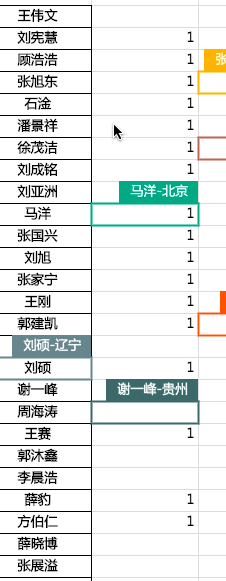

- 站长素材高清图片下载
    - 反爬机制：图片懒加载，广泛应用在了一些图片的网站中。
        - 只有当图片被显示在浏览器可视化范围之内才会将img的伪属性变成真正的属性。如果是requests发起的请求，requests请求是没有可视化范围，因此我们一定要解析的是img伪属性的属性值（图片地址）
- 学过的反爬机制：
    - robots
    - UA伪装
    - 动态加载数据的捕获
    - 图片懒加载

### 今日内容
- cookie
- 代理机制
- 验证码的识别
- 模拟登录

- cookie：
    - 是存储在客户端的一组键值对。
    - web中cookie的典型应用：
        - 免密登录
    - cookie和爬虫之间的关联
        - sometimes，对一张页面进行请求的时候，如果请求的过程中不携带cookie的话，那么我们是无法请求到正确的页面数据。因此cookie是爬虫中一个非常典型且常见的反爬机制。

- 需求：爬取雪球网中的咨询信息。https://xueqiu.com/
- 分析：
    - 1.判定爬取的咨询数据是否为动态加载的
        - 相关的更多咨询数据是动态加载的，滚轮滑动到底部的时候会动态加载出更多咨询数据。
    - 2.定位到ajax请求的数据包，提取出请求的url，响应数据为json形式的咨询数据

In [1]:
import requests
headers = {
    'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36'
}

In [2]:
url = 'https://xueqiu.com/v4/statuses/public_timeline_by_category.json?since_id=-1&max_id=20369434&count=15&category=-1'
page_text = requests.get(url=url,headers=headers).json()
page_text

{'error_description': '遇到错误，请刷新页面或者重新登录帐号后再试',
 'error_uri': '/v4/statuses/public_timeline_by_category.json',
 'error_data': None,
 'error_code': '400016'}

- 问题：我们没有请求到我们想要的数据
- 原因：我们没有严格意义上模拟浏览器发请求。
    - 处理：可以将浏览器发请求携带的请求头，全部粘贴在headers字典中，将headers作用到requests的请求操作中即可。

- cookie的处理方式
    - 方式1：手动处理
        - 将抓包工具中的cookie粘贴在headers中
        - 弊端：cookie如果过了有效时长则该方式失效。
    - 方式2：自动处理
        - 基于Session对象实现自动处理。
        - 如何获取一个session对象：requests.Session()返回一个session对象。
        - session对象的作用：
            - 该对象可以向requests一样调用get和post发起指定的请求。只不过如果在使用session发请求的过程中如果产生了cookie，则cookie会被自动存储到该session对象中，那么就意味着下次再次使用session对象发起请求，则该次请求就是携带cookie进行的请求发送。
        - 在爬虫中使用session的时候，session对象至少会被使用几次？
            - 两次。第一次使用session是为了将cookie捕获且存储到session对象中。下次的时候就是携带cookie进行的请求发送。

In [3]:
session = requests.Session() #创建好了sesion对象
#第一次使用session捕获且存储cookie，猜测对雪球网的首页发起的请求可能会产生cookie
main_url = 'https://xueqiu.com/'
session.get(main_url,headers=headers)#捕获且存储cookie

url = 'https://xueqiu.com/v4/statuses/public_timeline_by_category.json?since_id=-1&max_id=20369434&count=15&category=-1'
page_text = session.get(url=url,headers=headers).json() #携带cookie发起的请求
page_text

{'list': [{'id': 20369433,
   'category': 0,
   'data': '{"id":144858286,"title":"美股暴跌里的国运","description":"3月13日美东时间下午三点半，特朗普宣布美国进入国家紧急状态，承诺联邦政府将全力以赴抗击疫情。美股应声上涨，三大股指在收盘的半个小时内强势拉，收盘纷纷报涨逾9%，缓解了市场此前4个交易日两度熔断的恐慌情绪。 特朗普总统争分夺秒的再度天秀了一把，他将行情走势截图并签上了大名，送往美国...","target":"/4573323809/144858286","reply_count":97,"retweet_count":86,"topic_title":"美股熔断暴跌下的美国国运","topic_desc":"3月13日美东时间下午三点半，特朗普宣布美国进入国家紧急状...","topic_symbol":null,"topic_pic":null,"topic_pic_hd":null,"pic_type":0,"first_pic":null,"pic_size":{"width":2,"height":1},"pic":"","pic_sizes":[],"cover_pic":null,"user":{"id":4573323809,"profile":"/4573323809","description":"","following":false,"screen_name":"楚团长瞎扯淡","profile_image_url":"community/20166/1467794754492-1467794755056.jpg,community/20166/1467794754492-1467794755056.jpg!180x180.png,community/20166/1467794754492-1467794755056.jpg!50x50.png,community/20166/1467794754492-1467794755056.jpg!30x30.png","photo_domain":"http://xavatar.imedao.com/","verified_infos":[{"verified_type":"6","ver

- 代理操作
    - 在爬虫中，所谓的代理指的是什么？
        - 就是代理服务器
    - 代理服务器的作用是什么？
        - 就是用来转发请求和响应。
    - 在爬虫中为什么需要使用代理服务器？
        - 如果我们的爬虫在短时间内对服务器发起了高频的请求，那么服务器会检测到这样的一个异常的行为请求，就会将该请求对应设备的ip禁掉，就以为这client设备无法对服务器端再次进行请求发送。（ip被禁掉了）
        - 如果ip被禁，我们就可以使用代理服务器进行请求转发，破解ip被禁的反爬机制。因为使用代理后，服务器端接受到的请求对应的ip地址就是代理服务器而不是我们真正的客户端的。
    - 代理服务器分为不同的匿名度：
        - 透明代理：如果使用了该形式的代理，服务器端知道你使用了代理机制也知道你的真实ip。
        - 匿名代理：知道你使用代理，但是不知道你的真实ip
        - 高匿代理：不知道你使用了代理也不知道你的真实ip
    - 代理的类型
        - https：代理只能转发https协议的请求
        - http：转发http的请求
    - 代理服务器：
        - 快代理
        - 西祠代理
        - goubanjia
        - 代理精灵（推荐）：http://http.zhiliandaili.cn/)

- 封装一个代理池

In [4]:
from lxml import etree

In [7]:
url = 'http://t.11jsq.com/index.php/api/entry?method=proxyServer.generate_api_url&packid=1&fa=0&fetch_key=&groupid=0&qty=4&time=1&pro=&city=&port=1&format=html&ss=5&css=&dt=1&specialTxt=3&specialJson=&usertype=2'
page_text = requests.get(url,headers=headers).text
tree = etree.HTML(page_text)
proxy_list = tree.xpath('//body//text()')
http_proxy = [] #代理池
for proxy in proxy_list:
    dic = {
        'http':proxy
    }
    http_proxy.append(dic)
http_proxy

[{'http': '58.243.28.218:33503'},
 {'http': '114.106.151.234:10566'},
 {'http': '114.252.50.79:11484'},
 {'http': '106.7.4.131:28803'}]

- 对西祠代理发起一个高频的请求，让其将我本机ip禁掉

In [14]:
#url模板
url = 'https://www.xicidaili.com/nn/%d'
ips = []
for page in range(1,11):
    new_url = format(url%page)
    page_text = requests.get(url=new_url,headers=headers).text
    tree = etree.HTML(page_text)
    #在xpath表达式中不可以出现tbody标签
    tr_list = tree.xpath('//*[@id="ip_list"]//tr')[1:]
    for tr in tr_list:
        ip = tr.xpath('./td[2]/text()')[0]
        ips.append(ip)
print(len(ips))
        

AttributeError: 'NoneType' object has no attribute 'xpath'

- 使用代理机制破解ip被封的效果

In [16]:
import random

In [20]:
#代理池对应的代码
url = 'http://ip.11jsq.com/index.php/api/entry?method=proxyServer.generate_api_url&packid=1&fa=0&fetch_key=&groupid=0&qty=29&time=1&pro=&city=&port=1&format=html&ss=5&css=&dt=1&specialTxt=3&specialJson=&usertype=2'
page_text = requests.get(url,headers=headers).text
tree = etree.HTML(page_text)
proxy_list = tree.xpath('//body//text()')
http_proxy = [] #代理池
for proxy in proxy_list:
    dic = {
        'https':proxy
    }
    http_proxy.append(dic)

#url模板
url = 'https://www.xicidaili.com/nn/%d'
ips = []
for page in range(1,11):
    new_url = format(url%page)
    #让当次的请求使用代理机制，就可以更换请求的ip地址
    page_text = requests.get(url=new_url,headers=headers,proxies=random.choice(http_proxy)).text
    tree = etree.HTML(page_text)
    #在xpath表达式中不可以出现tbody标签
    tr_list = tree.xpath('//*[@id="ip_list"]//tr')[1:]
    for tr in tr_list:
        ip = tr.xpath('./td[2]/text()')[0]
        ips.append(ip)
print(len(ips))
        

1000


- 验证码的识别
    - 基于线上的打码平台识别验证码
    - 打码平台
        - 1.超级鹰（使用）：http://www.chaojiying.com/about.html
            - 1.注册【用户中心的身份】
            - 2.登录（用户中心的身份）
                - 1.查询余额，请充值
                - 2.创建一个软件ID（899370）
                - 3.下载示例代码
        - 2.云打码
        - 3.打码兔

In [21]:
#!/usr/bin/env python
# coding:utf-8

import requests
from hashlib import md5

class Chaojiying_Client(object):

    def __init__(self, username, password, soft_id):
        self.username = username
        password =  password.encode('utf8')
        self.password = md5(password).hexdigest()
        self.soft_id = soft_id
        self.base_params = {
            'user': self.username,
            'pass2': self.password,
            'softid': self.soft_id,
        }
        self.headers = {
            'Connection': 'Keep-Alive',
            'User-Agent': 'Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 5.1; Trident/4.0)',
        }

    def PostPic(self, im, codetype):
        """
        im: 图片字节
        codetype: 题目类型 参考 http://www.chaojiying.com/price.html
        """
        params = {
            'codetype': codetype,
        }
        params.update(self.base_params)
        files = {'userfile': ('ccc.jpg', im)}
        r = requests.post('http://upload.chaojiying.net/Upload/Processing.php', data=params, files=files, headers=self.headers)
        return r.json()

    def ReportError(self, im_id):
        """
        im_id:报错题目的图片ID
        """
        params = {
            'id': im_id,
        }
        params.update(self.base_params)
        r = requests.post('http://upload.chaojiying.net/Upload/ReportError.php', data=params, headers=self.headers)
        return r.json()


In [25]:
def tranformImgCode(imgPath,imgType):
    chaojiying = Chaojiying_Client('bobo328410948', 'bobo328410948', '899370')
    im = open(imgPath, 'rb').read()
    return chaojiying.PostPic(im,imgType)['pic_str']

In [26]:
print(tranformImgCode('./a.jpg',1902))

7261


- 模拟登录
    - 流程：
        - 对点击登录按钮对应的请求进行发送（post请求）
        - 处理请求参数：
            - 用户名
            - 密码
            - 验证码
            - 其他的防伪参数

In [27]:
#识别验证码
url = 'https://so.gushiwen.org/user/login.aspx?from=http://so.gushiwen.org/user/collect.aspx'
page_text = requests.get(url=url,headers=headers).text
#解析验证码图片的地址
tree = etree.HTML(page_text)
img_src = 'https://so.gushiwen.org'+tree.xpath('//*[@id="imgCode"]/@src')[0]
#将验证码图片保存到本地
img_data = requests.get(img_src,headers=headers).content
with open('./code.jpg','wb') as fp:
    fp.write(img_data)
    
#识别验证码
code_text = tranformImgCode('./code.jpg',1902)
print(code_text)
login_url ='https://so.gushiwen.org/user/login.aspx?from=http%3a%2f%2fso.gushiwen.org%2fuser%2fcollect.aspx'
data = {
    '__VIEWSTATE': '4iQUDYGYp480//d8dSe+k037Ut9ijESlrJJLPgCEsA+C4EAmEQV4h+p/G4sKwsGz2mFdGeIE+TS8T6Gru2w14b4n2qfsxdeB4caV4zXWhLNTbDM9m/heuikk8S4=',
    '__VIEWSTATEGENERATOR': 'C93BE1AE',
    'from': 'http://so.gushiwen.org/user/collect.aspx',
    'email': 'www.zhangbowudi@qq.com',
    'pwd': 'bobo328410948',
    'code': code_text,#动态变化
    'denglu': '登录',
}
#对点击登录按钮发起请求:获取了登录成功后对应的页面源码数据
page_text_login = requests.post(url=login_url,headers=headers,data=data).text
with open('./gushiwen.html','w',encoding='utf-8') as fp:
    fp.write(page_text_login)

m9vd


- 模拟登录失败了
- 原因：
    - cookie
    - 不可能是验证码的问题

- 携带cookie进行模拟登录

In [28]:
session = requests.Session()

#识别验证码
url = 'https://so.gushiwen.org/user/login.aspx?from=http://so.gushiwen.org/user/collect.aspx'
page_text = session.get(url=url,headers=headers).text
#解析验证码图片的地址
tree = etree.HTML(page_text)
img_src = 'https://so.gushiwen.org'+tree.xpath('//*[@id="imgCode"]/@src')[0]
#将验证码图片保存到本地
img_data = session.get(img_src,headers=headers).content
with open('./code.jpg','wb') as fp:
    fp.write(img_data)
    
#识别验证码
code_text = tranformImgCode('./code.jpg',1902)
print(code_text)
login_url ='https://so.gushiwen.org/user/login.aspx?from=http%3a%2f%2fso.gushiwen.org%2fuser%2fcollect.aspx'
data = {
    '__VIEWSTATE': '4iQUDYGYp480//d8dSe+k037Ut9ijESlrJJLPgCEsA+C4EAmEQV4h+p/G4sKwsGz2mFdGeIE+TS8T6Gru2w14b4n2qfsxdeB4caV4zXWhLNTbDM9m/heuikk8S4=',
    '__VIEWSTATEGENERATOR': 'C93BE1AE',
    'from': 'http://so.gushiwen.org/user/collect.aspx',
    'email': 'www.zhangbowudi@qq.com',
    'pwd': 'bobo328410948',
    'code': code_text,#动态变化
    'denglu': '登录',
}
#对点击登录按钮发起请求:获取了登录成功后对应的页面源码数据
page_text_login = session.post(url=login_url,headers=headers,data=data).text
with open('./gushiwen.html','w',encoding='utf-8') as fp:
    fp.write(page_text_login)

scvq


- 在请求参数中如果看到了一组乱序的请求参数，最好去验证码这组请求参数是否为动态变化。
- 处理：
    - 方式1：常规来讲一半动态变化的请求参数会被隐藏在前台页面中，那么我们就要去前台页面源码中取找。
    - 方式2：如果前台页面没有的话，我们就可以基于抓包工具进行全局搜索。

- 基于百度AI实现的爬虫功能
    - 图像识别
    - 语音识别&合成
    - 自然语言处理
    
- 使用流程：
    - 点击控制台进行登录
    - 选择想要实现的功能
    - 实现功能下创建一个app
    - 选择对应的pythonSDK文档进行代码实现

- 需求：https://duanziwang.com/
    - 将段子王中的段子内容爬取到本地，然后基于语音合成将段子合成为mp3的音频文件，然后自己搭建一个web服务器，线上实时播放音频文件。

- 爬取梨视频中的短视频数据：
- url：https://www.pearvideo.com/category_1
- 将最热板块下的短视频数据进行爬取且存储到本地。

- 预习：协程，基于asyncio模块。基于单线程+多任务的异步协程实现的异步爬虫。